# 1. Imports

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sklearn
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import SpatialDropout1D, Dropout, Bidirectional, Input, Embedding
from keras_tuner.tuners import RandomSearch
from keras_tuner import HyperParameters
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import re
import os
import string
import  random

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.shape

(7613, 5)

In [5]:
df.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

# 2. Data Exploration

In [6]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [10]:
df.keyword.nunique()

221

In [11]:
df.target.value_counts().sort_values(ascending=False)

target
0    4342
1    3271
Name: count, dtype: int64

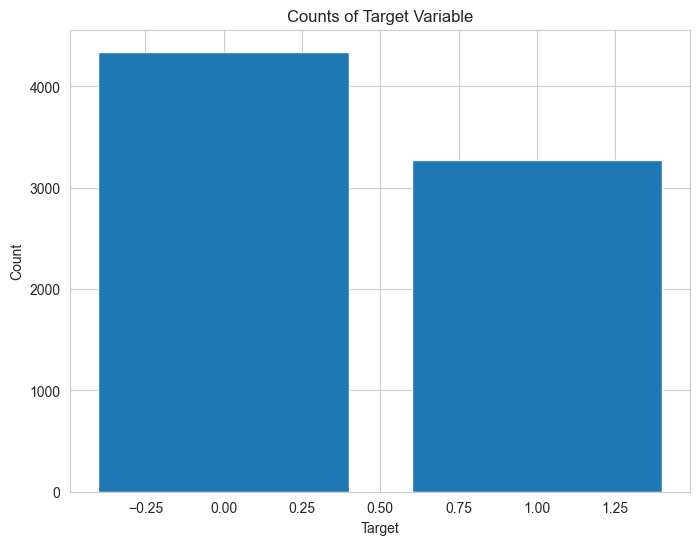

In [12]:
# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(df.target.value_counts().index, df.target.value_counts())

# Set plot title and labels
plt.title('Counts of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')

# Show the plot
plt.show()


In [13]:
df.keyword.value_counts().sort_values(ascending=False)

keyword
fatalities               45
armageddon               42
deluge                   42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64

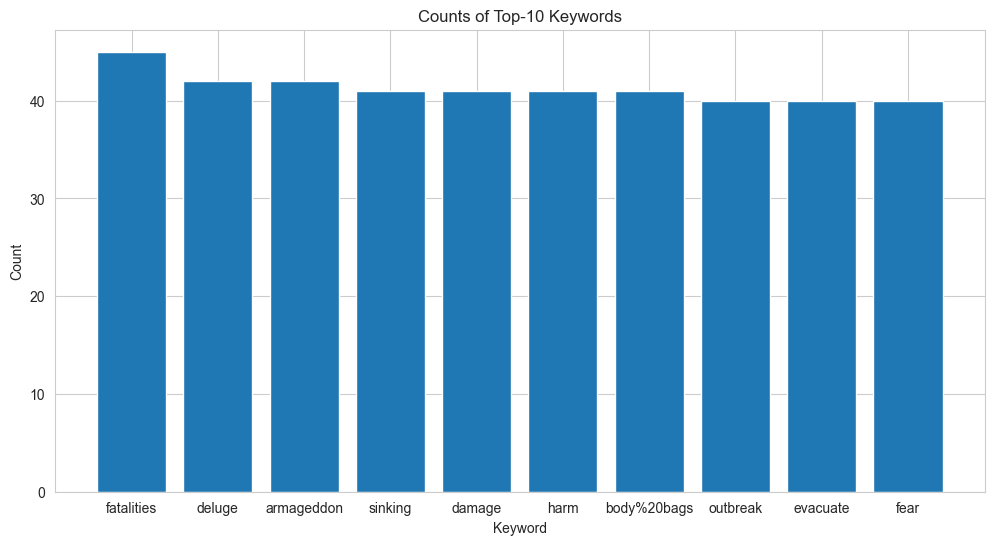

In [14]:
# Create bar plot
plt.figure(figsize=(12, 6))
plt.bar(df.keyword.value_counts().index[:10], df.keyword.value_counts()[:10])

# Set plot title and labels
plt.title('Counts of Top-10 Keywords')
plt.xlabel('Keyword')
plt.ylabel('Count')

# Show the plot
plt.show()

The code has calculated the text length statistics for training and test datasets, showing the average text length is around 101 characters for both. It also tokenizes texts from both datasets, identifying 22,700 unique tokens in the training set and 12,818 in the test set, indicating a rich vocabulary used across the texts.

# 3. Preprocessing

In [15]:
# To ensure reproducibility in the experiments, we fix the random seed for all components in the code
seed_value=1

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set Python built-in pseudorandom generator at a fixed value
random.seed(seed_value)

# 3. Set NumPy pseudorandom generator at a fixed value
np.random.seed(seed_value)

# 4. Set TensorFlow pseudorandom generator at a fixed value
tf.random.set_seed(seed_value)

In [16]:
# Function to lowercase the text and remove punctuation
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    return tf.strings.regex_replace(lowercase, '[{}]'.format(re.escape(string.punctuation)), '')

In [17]:
# Define the vocabulary size and the number of words in a sequence.
vocab_size = 4096
sequence_length = 10

# Vectorize layer
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

In [18]:
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
    targets, contexts, labels = [], [], []

    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

    for sequence in tf.data.Dataset.from_tensor_slices(sequences).as_numpy_iterator():
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocab_size,
            sampling_table=sampling_table,
            window_size=window_size,
            negative_samples=0)

        for target_word, context_word in positive_skip_grams:
            context_class = tf.expand_dims(tf.constant([context_word], dtype="int64"), 1)
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
                true_classes=context_class,
                num_true=1,
                num_sampled=num_ns,
                unique=True,
                range_max=vocab_size,
                seed=seed,
                name="negative_sampling")
            context = tf.concat([tf.squeeze(context_class, 1), negative_sampling_candidates], 0)
            label = tf.constant([1] + [0] * num_ns, dtype="int64")

            targets.append(target_word)
            contexts.append(context)
            labels.append(label)

    return targets, contexts, labels

In [19]:
# Prepare X and y data
X = df['text']
y = df['target']

# Split data into train and validate sets
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Sequence encode
encoded_train = tokenizer.texts_to_sequences(X_train)
encoded_validate = tokenizer.texts_to_sequences(X_validate)

# Pad sequences
max_length = 60
X_train_padded = pad_sequences(encoded_train, maxlen=max_length, padding='post')
X_validate_padded = pad_sequences(encoded_validate, maxlen=max_length, padding='post')

# Ensure the y data is in the right shape
if isinstance(y_train, pd.Series):
    y_train = y_train.values.reshape(-1, 1)
if isinstance(y_validate, pd.Series):
    y_validate = y_validate.values.reshape(-1, 1)

print("Train dataset size: ", X_train_padded.shape[0])
print("Validate dataset size: ", X_validate_padded.shape[0])
print('Max length: ', max_length)


Train dataset size:  6090
Validate dataset size:  1523
Max length:  60


In [29]:
def build_model(hp: HyperParameters):
    model = Sequential()
    model.add(Input(shape=(60,)))
    model.add(Embedding(input_dim=20000, output_dim=hp.Int('embedding_output_dim', min_value=32, max_value=1024, step=32)))
    model.add(Bidirectional(LSTM(units=hp.Int('lstm_units_1', min_value=32, max_value=1024, step=32), return_sequences=True, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5))))
    model.add(Bidirectional(LSTM(units=hp.Int('lstm_units_2', min_value=32, max_value=1024, step=32), return_sequences=True, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5))))
    model.add(Bidirectional(LSTM(units=hp.Int('lstm_units_3', min_value=32, max_value=1024, step=32), return_sequences=False, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5))))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5])), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Assuming you have defined and prepared X_train_padded, y_train, X_validate_padded, y_validate beforehand

tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=10, executions_per_trial=3, directory='my_dir', project_name='keras_tuning_advanced')
tuner.search(x=X_train_padded, y=y_train, epochs=10, validation_data=(X_validate_padded, y_validate), callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

best_hps = tuner.get_best_hyperparameters()[0]

# Now, you should only instantiate, train, and evaluate your model once with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_padded, y_train, epochs=10, validation_data=(X_validate_padded, y_validate), callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print(f'Best epoch: {best_epoch}')

model.fit(X_train_padded, y_train, epochs=best_epoch)
val_loss, val_accuracy = model.evaluate(X_validate_padded, y_validate)

print(f"Validation accuracy: {val_accuracy}")


Trial 11 Complete [00h 09m 14s]
val_accuracy: 0.8104618191719055

Best val_accuracy So Far: 0.8151674270629883
Total elapsed time: 07h 33m 37s
Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 97ms/step - accuracy: 0.5802 - loss: 0.7665 - val_accuracy: 0.7774 - val_loss: 0.6009
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - accuracy: 0.8061 - loss: 0.5225 - val_accuracy: 0.7768 - val_loss: 0.5256
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.8985 - loss: 0.3376 - val_accuracy: 0.8024 - val_loss: 0.5614
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.9385 - loss: 0.2365 - val_accuracy: 0.7571 - val_loss: 0.6775
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.9622 - loss: 0.1678 - val_accuracy: 0.7794 - val_loss: 0.7717
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.9747 - loss: 0.1269 - val_accuracy: 0.7485 - val_loss: 0.9538
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.9829 - lo

In [27]:
from keras_tuner import HyperParameters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers


def build_model(hp: HyperParameters):
    model = Sequential()
    model.add(Embedding(
        input_dim=10000,
        output_dim=hp.Int('output_dim', min_value=32, max_value=512, step=32),
        input_length=32  # Adjust based on your sequence length
    ))
    model.add(LSTM(
        units=hp.Int('units', min_value=32, max_value=512, step=32),
        return_sequences=True,
        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.l2(1e-4),
        activity_regularizer=regularizers.l2(1e-5)
    ))
    model.add(LSTM(
        units=hp.Int('units', min_value=32, max_value=512, step=32),
        return_sequences=True,
        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.l2(1e-4),
        activity_regularizer=regularizers.l2(1e-5)
    ))
    model.add(LSTM(
        units=hp.Int('units', min_value=32, max_value=512, step=32),
        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.l2(1e-4),
        activity_regularizer=regularizers.l2(1e-5)
    ))
    model.add(Dropout(
        hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)  # Adjust its range as needed
    ))
    model.add(Dense(
        1,
        activation='sigmoid'
    ))
    model.compile(
        optimizer=Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [28]:
batch_sizes = [32, 64, 128, 256]

for batch_size in batch_sizes:
    print(f"\nTraining with batch size: {batch_size}")
    
    tuner = RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=5, # reduced for demonstration
        executions_per_trial=2,
        directory='my_dir',
        project_name=f'keras_tuning_bs_{batch_size}'
    )
    
    tuner.search(x=X_train_padded, y=y_train, epochs=10, batch_size=batch_size,
                 validation_data=(X_validate_padded, y_validate),
                 callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
    
    # Fetch the best hyperparameters and print them
    best_hps = tuner.get_best_hyperparameters()[0]
    print(f"\nBest Hyperparameters for batch_size: {batch_size}:")
    print(f"Optimal number of units: {best_hps.get('units')}")
    print(f"Optimal output dimension: {best_hps.get('output_dim')}")
    print(f"Optimal dropout rate: {best_hps.get('dropout_rate')}")
    print(f"Optimal learning rate: {best_hps.get('learning_rate')}")
    
    # Build the model with the optimal hyperparameters and train it on the data
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(X_train_padded, y_train, epochs=10, batch_size=batch_size,
                        validation_data=(X_validate_padded, y_validate),
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

    # Get the best epoch with the highest validation accuracy
    val_acc_per_epoch = history.history['val_accuracy']
    best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
    print(f"\nBest epoch for batch_size {batch_size}: {best_epoch}")

    # Re-instantiate the hypermodel and train it with the optimal number of epochs from above.
    hypermodel = tuner.hypermodel.build(best_hps)

    # Retrain the model
    hypermodel.fit(X_train_padded, y_train, epochs=best_epoch, batch_size=batch_size)

    # Evaluate the hypermodel on the validation set
    val_loss, val_accuracy = hypermodel.evaluate(X_validate_padded, y_validate)
    print(f"Validation accuracy for batch_size {batch_size}: {val_accuracy}\n{'-'*50}")


Training with batch size: 32


ValueError: Unrecognized keyword arguments passed to Embedding: {'input_length': 32}

In [25]:
from keras_tuner import HyperParameters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers


def build_model(hp: HyperParameters):
    model = Sequential()
    model.add(Embedding(
        input_dim=10000,
        output_dim=hp.Int('output_dim', min_value=32, max_value=512, step=32),
        input_length=100  # Adjust based on your sequence length
    ))
    model.add(LSTM(
        units=hp.Int('units', min_value=32, max_value=512, step=32),
        return_sequences=True,
        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.l2(1e-4),
        activity_regularizer=regularizers.l2(1e-5)
    ))
    model.add(LSTM(
        units=hp.Int('units', min_value=32, max_value=512, step=32),
        return_sequences=True,
        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.l2(1e-4),
        activity_regularizer=regularizers.l2(1e-5)
    ))
    model.add(LSTM(
        units=hp.Int('units', min_value=32, max_value=512, step=32),
        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.l2(1e-4),
        activity_regularizer=regularizers.l2(1e-5)
    ))
    model.add(Dropout(
        hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)  # Adjust its range as needed
    ))
    model.add(Dense(
        1,
        activation='sigmoid'
    ))
    model.compile(
        optimizer=Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='keras_tuning_advanced'
)

batch_size = hp.Int('batch_size', min_value=32, max_value=256, step=32)

tuner.search(x=X_train_padded, y=y_train, epochs=10, batch_size=batch_size,
             validation_data=(X_validate_padded, y_validate),
             callbacks=[EarlyStopping(monitor='val_loss', patience=3)])


# Fetch the best hyperparameters and print them
best_hps = tuner.get_best_hyperparameters()[0]
print(f"Optimal number of units: {best_hps.get('units')}")
print(f"Optimal output dimension: {best_hps.get('output_dim')}")
print(f"Optimal dropout rate: {best_hps.get('dropout_rate')}")
print(f"Optimal learning rate: {best_hps.get('learning_rate')}")

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_padded, y_train, epochs=10,
                    validation_data=(X_validate_padded, y_validate),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

# Get the best epoch with the highest validation accuracy
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

# Re-instantiate the hypermodel and train it with the optimal number of epochs from above.
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train_padded, y_train, epochs=best_epoch)

# Evaluate the hypermodel on the validation set
val_loss, val_accuracy = hypermodel.evaluate(X_validate_padded, y_validate)

print("Validation accuracy: ", val_accuracy)


Reloading Tuner from my_dir\keras_tuning_advanced\tuner0.json


NameError: name 'hp' is not defined

In [18]:
'''from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
'''
from keras_tuner import HyperParameters
def build_model(hp: HyperParameters):
    model = Sequential()
    model.add(Embedding(
        input_dim=10000,
        output_dim=hp.Int('output_dim', min_value=32, max_value=512, step=32)
    ))
    model.add(Dropout(
        hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    ))
    model.add(LSTM(
        units=hp.Int('units', min_value=32, max_value=512, step=32),
        return_sequences=True
    ))
    # Optionally add a condition to decide whether to return sequences
    model.add(LSTM(
        units=hp.Int('units', min_value=32, max_value=512, step=32)
    ))
    model.add(Dropout(
        hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    ))
    model.add(Dense(
        1,
        activation='sigmoid'
    ))
    model.compile(
        optimizer=Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [19]:

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Increased number of trials
    executions_per_trial=2,  # More executions per trial to average out performance
    directory='my_dir',
    project_name='keras_tuning_advanced'
)

tuner.search(x=X_train_padded, y=y_train, epochs=10,
             validation_data=(X_validate_padded, y_validate),
             callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

# Fetch the best hyperparameters and print them
best_hps = tuner.get_best_hyperparameters()[0]
print(f"Optimal number of units: {best_hps.get('units')}")
print(f"Optimal output dimension: {best_hps.get('output_dim')}")
print(f"Optimal dropout rate: {best_hps.get('dropout_rate')}")
print(f"Optimal learning rate: {best_hps.get('learning_rate')}")


Reloading Tuner from my_dir\keras_tuning_advanced\tuner0.json
Optimal number of units: 160
Optimal output dimension: 224
Optimal dropout rate: 0.30000000000000004
Optimal learning rate: 0.0002515869363015755


In [20]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_padded, y_train, epochs=10,
                    validation_data=(X_validate_padded, y_validate),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

# Get the best epoch with the highest validation accuracy
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

# Re-instantiate the hypermodel and train it with the optimal number of epochs from above.
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train_padded, y_train, epochs=best_epoch)

# Evaluate the hypermodel on the validation set
val_loss, val_accuracy = hypermodel.evaluate(X_validate_padded, y_validate)

print("Validation accuracy: ", val_accuracy)


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 39s 175ms/step - accuracy: 0.5521 - loss: 0.6870 - val_accuracy: 0.5739 - val_loss: 0.6824
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 35s 184ms/step - accuracy: 0.5678 - loss: 0.6846 - val_accuracy: 0.7072 - val_loss: 0.5950
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 34s 177ms/step - accuracy: 0.7378 - loss: 0.5791 - val_accuracy: 0.7479 - val_loss: 0.5598
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 34s 181ms/step - accuracy: 0.7904 - loss: 0.5016 - val_accuracy: 0.7485 - val_loss: 0.5693
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 32s 169ms/step - accuracy: 0.7746 - loss: 0.5213 - val_accuracy: 0.6087 - val_loss: 0.6513
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 34s 179ms/step - accuracy: 0.5888 - loss: 0.6470 - val_accuracy: 0.5739 - val_loss: 0.6829
Best epoch: 4
Epoch 1/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 33s 151ms/step - accuracy: 0.5801 - loss: 0.6834
Epoch 2/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 29s 152ms/step - accuracy: 0.5741 - loss: 0.6832
Epoch 3/4
191/191 ━━━━━━